# Project Objective
Predict churn and surface actionable drivers so marketing can prioritize proactive retention.

# Step 1: Import library & Load the Dataset

In [25]:
#import library 
import pandas as pd

#locate file path 
file_path = "/Users/jonighmcgee/Downloads/Telco-Customer-Churn.csv"

#load dataset 
df = pd.read_csv(file_path)

# Preview
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Step 2: Quick Data Check

In [26]:
# Check missing values
print(df.isnull().sum()) # No missing values


# Check data types
print(df.dtypes)

# Look at churn distribution
print(df['Churn'].value_counts(normalize=True))

## value_counts give raw counts
## normalize=True gives proportion instead of counts
## dataset imblanced; 73% customers stayed v 27% churned 
## will later resample (class_weight='balanced', SMOTE, F1 score)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      f

# Step 3: Basic Visualization (EDA)

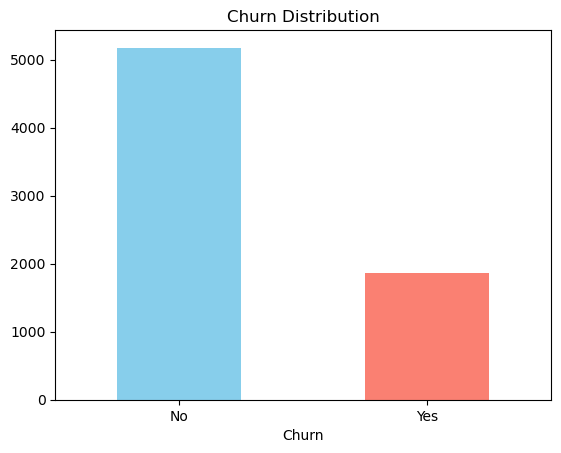

In [27]:
import matplotlib.pyplot as plt

# Distribution of target variable
df['Churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Churn Distribution")
plt.xticks(rotation=0) #keeps labels horizontal
plt.show()


The churn distribution shows that about **73% of customers stayed** (No) and **27% left** (Yes).  
This confirms that the dataset is **imbalanced**.

# Step 4: Logistic Regression 

4.1 Encode categorical variables.
Encoding converts categorical (text-based) values into numeric format so that machine learning algorithms can process and interpret them

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target (Churn) as 0/1
# The raw Churn column contained string labels "Yes" and "No"
# ML model needs numeric values 
# Result is a binary target variable ready for classification "Yes" = 1(Churn), "No" = 0(Stayed)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Convert TotalCharges to numeric 
# The raw TotalCharges column is stored as text (object), some rows are blank strings "" (not considered NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # "" become NaN; not valid numbers
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median()) #fill NaN with median
#median robust to outliers and keeps all rows

# One-hot encode categorical features, #Drop indentifier 'cusomerID' not usefel for prediction
# pd.get_dummies() turns each category into binary (0/1) columns
df_encoded = pd.get_dummies(df.drop(columns=['customerID']), drop_first=True)

# Split features and target
# X = all independent variables / features / predictors
# y = dependent variable / target / what's being predicted
X = df_encoded.drop('Churn', axis=1) #drop churn because it is not a feature, it's the target
y = df_encoded['Churn'] # target being predicted

# Train-test split 
# Training set 80% : model learns new patterns ; find math relationships that minimize error on training data
# Test set 20% : model evaluated on unseen data
# stratify = y keeps the same ratio (73/27) in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5634, 30)
Test shape: (1409, 30)


4.2 Train Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report

# Train baseline logistic regression
# Predicts probability that customer belongs to a class 0 or 1
# max_iter = 1000 gives the optimizer enough steps to converge 
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]  # Probabilities for log loss

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_proba))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8041163946061036
Log Loss: 0.4208970568722828
F1 Score: 0.6011560693641619

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.80      0.80      1409



My baseline logistic regression achieved 80% accuracy, but because churn is imbalanced, accuracy alone is  misleading. The F1 score for churners was only 0.60 with recall at 56%, meaning the model missed almost half of actual churners. This highlights the need for imbalance handling, which I later address in step 5 using class weighting and SMOTE.

# Step 4 Conclusion
Overall, the baseline is strong at predicting customers who stay, but weaker at identifying those likely to leave — which is why I moved on to imbalance handling (class weights, SMOTE). 

My model reached 80% accuracy, but because the dataset is imbalanced (73% stayed vs 27% churned), accuracy is misleading.

Log Loss (0.42) shows the probability estimates are decent but not perfect.

For non-churners, the model performs well (Precision 0.85, Recall 0.89, F1 0.87).

For churners, it struggles (Precision 0.65, Recall 0.56, F1 0.60), meaning it misses many at-risk customers.

# Step 5: Imbalance Handling (class weights + SMOTE)

5.1 Logistic Regression with class weights

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

# Class-weighted logistic regression
# solver='lbfgs' is the optimization algorithm that finds the best coefficients for the model
# class_weight = 'balanced' allows model to give more importance to minority class (churners)
log_reg_bal = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
log_reg_bal.fit(X_train, y_train)

y_pred_bal  = log_reg_bal.predict(X_test)
y_proba_bal = log_reg_bal.predict_proba(X_test)[:, 1]

print("F1 (balanced):", f1_score(y_test, y_pred_bal))
print("ROC-AUC (balanced):", roc_auc_score(y_test, y_proba_bal))
print("\nClassification Report (balanced):\n", classification_report(y_test, y_pred_bal))
print("Confusion Matrix (balanced):\n", confusion_matrix(y_test, y_pred_bal))


F1 (balanced): 0.616193480546793
ROC-AUC (balanced): 0.842664496628691

Classification Report (balanced):
               precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix (balanced):
 [[751 284]
 [ 81 293]]


Logistic regression with class weights improved recall for churners from 56% to 78%, which means I'm catching more customers who actually churn. Precision and accuracy dropped because now I am predicting churn more, which may lead to false positives. ROC-AUC stayed the same meaning model's ranking power didn't change, it just shifted how it decides 0 and 1.

Recall increased, so the model has improved at identifying churners. Precision and accuracy declined, which is only an issue if I care about bothering loyal customers with false alerts. From a business standpoint,this trade-off is acceptable because it’s usually better to incorrectly flag a loyal customer than to miss a customer who is about to churn. Losing a customer has a much higher cost than reaching out unnecessarily.

5.2 Logistic Regression with SMOTE oversampling. Apply SMOTE only to the training set (to avoid leakage), then train a standard logistic regression.

In [31]:
from imblearn.over_sampling import SMOTE
# Logistic Regression with SMOTE oversampling
# SMOTE creates synthetic data for minority class 'Churn' in the training set only
# This balances the dataset so the model doesn't get too biased toward majority 
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

log_reg_sm = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg_sm.fit(X_train_sm, y_train_sm)

y_pred_sm  = log_reg_sm.predict(X_test)
y_proba_sm = log_reg_sm.predict_proba(X_test)[:, 1]

print("F1 (SMOTE):", f1_score(y_test, y_pred_sm))
print("ROC-AUC (SMOTE):", roc_auc_score(y_test, y_proba_sm))
print("\nClassification Report (SMOTE):\n", classification_report(y_test, y_pred_sm))
print("Confusion Matrix (SMOTE):\n", confusion_matrix(y_test, y_pred_sm))


F1 (SMOTE): 0.5781057810578105
ROC-AUC (SMOTE): 0.8089694902994135

Classification Report (SMOTE):
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1035
           1       0.54      0.63      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.76      0.76      1409

Confusion Matrix (SMOTE):
 [[831 204]
 [139 235]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SMOTE helps the model “see” more churn examples during training, but the synthetic data may not generalize well. In this case, class weights were more effective than SMOTE.

SMOTE did increase recall for churners (63% vs baseline 56%).

However, it hurt precision and overall performance.

The F1 score (0.58) and ROC-AUC (0.81) show that SMOTE oversampling did not work as well as class-weighted logistic regression for this dataset.

5.3 (Optional) Precision–Recall curve

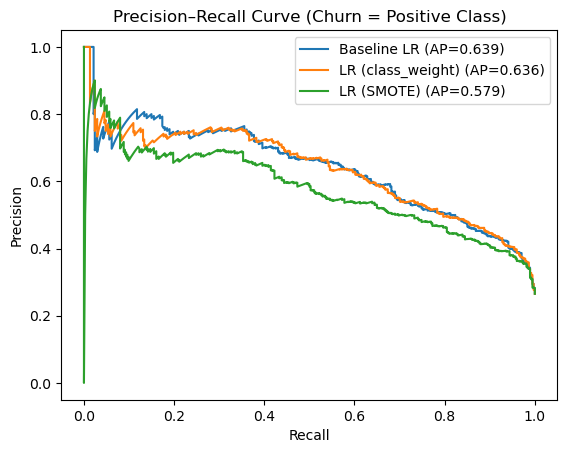

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# A PR curve focuses directly on minority class
# It visualizes how well each model catches churners without too many false positives 

for name, y_score in {
    "Baseline LR": y_proba,            # from Step 4
    "LR (class_weight)": y_proba_bal,
    "LR (SMOTE)": y_proba_sm
}.items():
    p, r, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Churn = Positive Class)")
plt.legend()
plt.show()


#  Step 5 Conclusion
The baseline logistic regression provided the best performance (AP = .639). Adjusting for class imbalance with class weights did not significantly improve results, and using SMOTE actually reduced performance. For this dataset, oversampling didn't help, and the baseline model remains the most effective for predicting churn.


# Step 6: Tree-Based Models (RF, GB, XGBoost) + Bagging vs Boosting

6.1 Train & Evaluate: Random Forest (Bagging)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

# Random Forest (bagging): uses bootstrap samples + random feature subsets at each split
# Bagging (bootstrap aggregating) reduces overfitting and variance by training many trees on different 
# random subsets of the data and averaging their predictions
rf = RandomForestClassifier(
    n_estimators=400, # Number of decision trees
    class_weight='balanced',  # Gives more weight to minority class; helps with imbalance
    n_jobs=-1, # Uses all available CPU cores in parallel to speed up training
    random_state=42,
    oob_score=True # Uses "out-of-bag" samples as built-in test data to estimate accuracy w/o sepearate validation set
)
rf.fit(X_train, y_train)

rf_pred  = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("Random Forest — F1:", f1_score(y_test, rf_pred))
print("Random Forest — ROC-AUC:", roc_auc_score(y_test, rf_proba))
print("Random Forest — OOB Score:", rf.oob_score_)
print("\nClassification Report (RF):\n", classification_report(y_test, rf_pred))
print("Confusion Matrix (RF):\n", confusion_matrix(y_test, rf_pred))


Random Forest — F1: 0.5473684210526316
Random Forest — ROC-AUC: 0.8245485545997054
Random Forest — OOB Score: 0.7889598864039759

Classification Report (RF):
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

Confusion Matrix (RF):
 [[926 109]
 [192 182]]


Random Forest is good at general classification, but for this imbalanced churn problem, it underperforms logistic regression with class weights. It predicts non-churners well but isn’t aggressive enough in catching churners.

Strengths:
Random Forest is stable and accurate overall (79% accuracy, 0.82 ROC-AUC).
Strong performance for non-churners.

Weaknesses:
Struggled with recall for churners (49%), meaning it misses many at-risk customers.
F1 score dropped compared to logistic regression.

6.2 Train & Evaluate: Gradient Boosting (Boosting)

In [34]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Class-balanced sample weights (HGBC doesn't have class_weight param)
sw = compute_sample_weight(class_weight='balanced', y=y_train)

gb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_depth=None,   # grow until min_samples constraints
    max_iter=400,
    random_state=42
)
gb.fit(X_train, y_train, sample_weight=sw)

gb_pred  = gb.predict(X_test)
gb_proba = gb.predict_proba(X_test)[:, 1]

print("Gradient Boosting — F1:", f1_score(y_test, gb_pred))
print("Gradient Boosting — ROC-AUC:", roc_auc_score(y_test, gb_proba))
print("\nClassification Report (GB):\n", classification_report(y_test, gb_pred))
print("Confusion Matrix (GB):\n", confusion_matrix(y_test, gb_pred))


Gradient Boosting — F1: 0.602641056422569
Gradient Boosting — ROC-AUC: 0.8215867111007775

Classification Report (GB):
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.67      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.78      0.77      0.77      1409

Confusion Matrix (GB):
 [[827 208]
 [123 251]]


Gradient Boosting improved the model’s ability to detect churners compared to Random Forest, trading a small drop in overall accuracy for significantly higher recall and F1 score on the churn class.

F1 (Churners): Improved from 0.55 (RF) → 0.60 (GB)

Recall (Churners): Increased from 0.49 (RF) → 0.67 (GB), reducing missed churners by ~36%

Business Impact: Better at catching customers likely to leave, enabling stronger retention strategies even with slightly more false alarms

6.3 Train & Evaluate: XGBoost (Boosting, regularized)

In [ ]:
pip install xgboost

In [35]:
try:
    from xgboost import XGBClassifier

    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    scale_pos_weight = neg / pos  # handles imbalance

    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        tree_method='hist',
        scale_pos_weight=scale_pos_weight
    )
    xgb.fit(X_train, y_train)

    xgb_pred  = xgb.predict(X_test)
    xgb_proba = xgb.predict_proba(X_test)[:, 1]

    print("XGBoost — F1:", f1_score(y_test, xgb_pred))
    print("XGBoost — ROC-AUC:", roc_auc_score(y_test, xgb_proba))
    print("\nClassification Report (XGB):\n", classification_report(y_test, xgb_pred))
    print("Confusion Matrix (XGB):\n", confusion_matrix(y_test, xgb_pred))
except Exception as e:
    print("XGBoost not available or failed to run:", e)


XGBoost — F1: 0.5963636363636363
XGBoost — ROC-AUC: 0.8253339016766127

Classification Report (XGB):
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.66      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409

Confusion Matrix (XGB):
 [[830 205]
 [128 246]]


XGBoost delivered the strongest overall balance, achieving the highest ROC-AUC while maintaining solid F1 and recall for churners, making it a reliable choice for churn prediction.

ROC-AUC = 0.825 best among the three models, strong class separation.

F1 (Churners) = 0.60 on par with Gradient Boosting, higher than Random Forest.

Recall (Churners) = 0.66 big improvement vs RF (0.49), nearly as strong as GB (0.67).

Tradeoff: Slightly lower accuracy (76%) compared to RF (79%), but gains in catching churners outweigh the drop.

6.4 Compare Models (F1, ROC-AUC)

In [36]:
import pandas as pd

# Create list of rows containing each model name along with its F1 score and ROC-AUC
rows = [
    ("LogReg Baseline", f1_score(y_test, y_pred), roc_auc_score(y_test, y_proba)),
    ("LogReg (class_weight)", f1_score(y_test, y_pred_bal), roc_auc_score(y_test, y_proba_bal)),
    ("LogReg (SMOTE)", f1_score(y_test, y_pred_sm), roc_auc_score(y_test, y_proba_sm)),
    ("RandomForest", f1_score(y_test, rf_pred), roc_auc_score(y_test, rf_proba)),
    ("GradBoost (HGB)", f1_score(y_test, gb_pred), roc_auc_score(y_test, gb_proba)),
]

try:
    rows.append(("XGBoost", f1_score(y_test, xgb_pred), roc_auc_score(y_test, xgb_proba)))
except:
    pass
# Store rows in DataFrame and sort by F1 to easily compare performance across models
score_df = pd.DataFrame(rows, columns=["Model", "F1", "ROC_AUC"]).sort_values("F1", ascending=False)
score_df


,Model,F1,ROC_AUC
1,LogReg (class_weight),0.616193,0.842664
4,GradBoost (HGB),0.602641,0.821587
0,LogReg Baseline,0.601156,0.841693
5,XGBoost,0.596364,0.825334
2,LogReg (SMOTE),0.578106,0.808969
3,RandomForest,0.547368,0.824549


Overall, the Logistic Regression with class weights delivered the best F1 score, while boosting models (GB, XGBoost) offered strong balance between F1 and ROC-AUC. Random Forest, despite high accuracy and ROC-AUC, underperformed on F1 due to poor recall for churners.

Key Results:

LogReg (class_weight) : Best F1 (0.616) and strong ROC-AUC (0.843). Great at catching churners with imbalance handling.

GradBoost (HGB) : F1 = 0.603, ROC-AUC = 0.822. Consistent and balanced, slightly behind weighted LogReg.

LogReg Baseline : Surprisingly competitive (F1 = 0.601, ROC-AUC = 0.842), showing logistic regression is a solid baseline.

XGBoost : F1 = 0.596, ROC-AUC = 0.825. Strong ROC-AUC but slightly lower F1 than LogReg/HGB.

LogReg (SMOTE) : F1 = 0.578, ROC-AUC = 0.809. Some improvement in recall, but not as strong overall.

Random Forest : Lowest F1 (0.547) despite a high ROC-AUC (0.825). Great at predicting non-churners, but missed many churners.

 6.5 Feature Importance (Top Drivers)

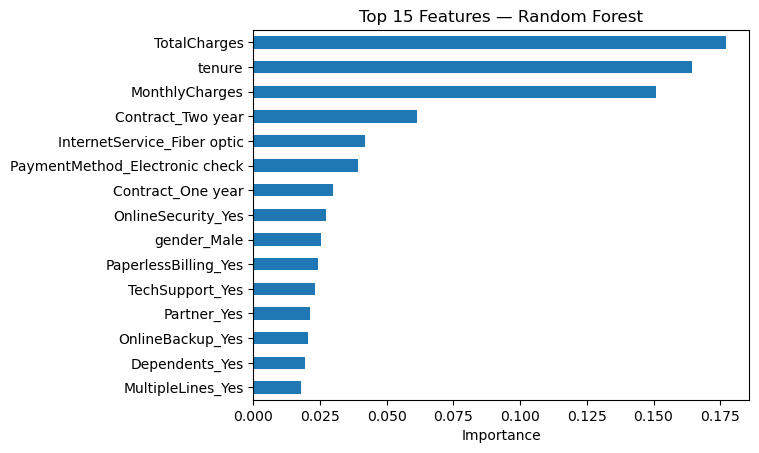

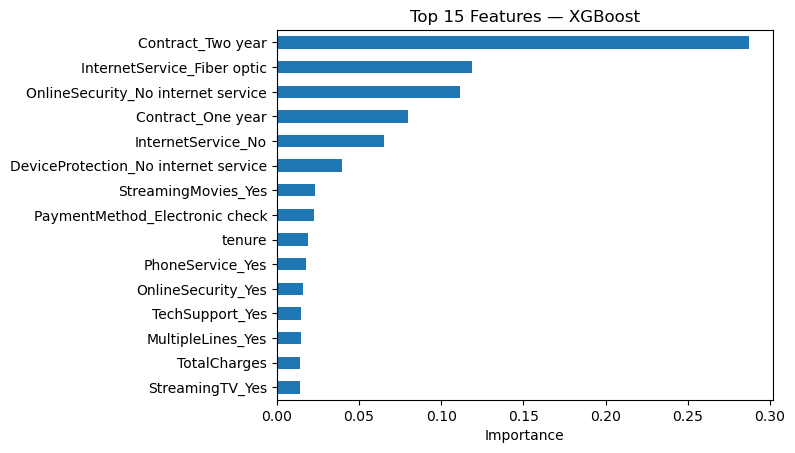

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Random Forest importances
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
rf_imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Features — Random Forest")
plt.xlabel("Importance")
plt.show()

# XGBoost importances (if available)
try:
    xgb_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
    xgb_imp.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Top 15 Features — XGBoost")
    plt.xlabel("Importance")
    plt.show()
except:
    pass


# 6.5 Conclusion
Random Forest is highlighting financial, tenure, and contract type as the strongest drivers, with service and demographics as secondary factors.
XGBoost seems to find contract type and internet / service features more predictive than pure billing amounts.

This difference happens because Random Forest averages across many trees while XGBoost builds sequentially to reduce errors, so it "zooms in" on patterns like contract and service churn.

In practice, it'd be best to combine these insights. Customers with month-to-month contracts, fiber optic service, electronic check payments, and shorter tenure are at the highest churn risk. Customers with longer contracts, higher tenure, and bundle services how lower churn risk.

# Step 7: ROC Curves for Best Models

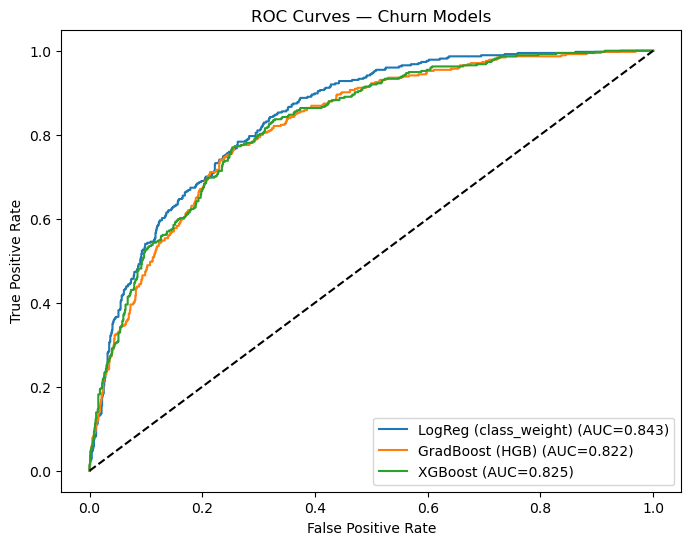

In [38]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, y_score in {
    "LogReg (class_weight)": y_proba_bal,
    "GradBoost (HGB)": gb_proba,
    "XGBoost": xgb_proba
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Churn Models")
plt.legend()
plt.show()

# Step 7 Conclusion
All three models perform fairly well. Logistic regression slightly outperforms the others. Since ROC/AUC evaluates a model's ability to distinguish between churn vs. non-churn across all thresholds, I can conclude Logistic Regression is the best classifier in this set.

# Step 8 — Pick an operating threshold (beyond 0.50)

In [39]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# pick the model you want to deploy; here I'll use the best so far: LogReg (class_weight)
proba = y_proba_bal  # change to gb_proba or xgb_proba if you prefer those

def sweep_thresholds(y_true, y_scores, thresholds=np.arange(0.2, 0.81, 0.02)):
    rows = []
    for t in thresholds:
        y_hat = (y_scores >= t).astype(int)
        p = precision_score(y_true, y_hat)
        r = recall_score(y_true, y_hat)
        f1 = f1_score(y_true, y_hat)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append((float(t), p, r, f1, tp, fp, tn, fn))
    return pd.DataFrame(rows, columns=["threshold","precision","recall","f1","tp","fp","tn","fn"])

thr_df = sweep_thresholds(y_test, proba)
thr_df.sort_values("f1", ascending=False).head(10)


,threshold,precision,recall,f1,tp,fp,tn,fn
23,0.66,0.586288,0.663102,0.622334,248,175,860,126
18,0.56,0.534749,0.740642,0.621076,277,241,794,97
17,0.54,0.526022,0.756684,0.620614,283,255,780,91
16,0.52,0.517117,0.767380,0.617869,287,268,767,87
12,0.44,0.487578,0.839572,0.616896,314,330,705,60
22,0.64,0.568849,0.673797,0.616891,252,191,844,122
15,0.50,0.507799,0.783422,0.616193,293,284,751,81
21,0.62,0.557484,0.687166,0.615569,257,204,831,117
24,0.68,0.598985,0.631016,0.614583,236,158,877,138
25,0.70,0.619565,0.609626,0.614555,228,140,895,146


8.2 Pick a threshold

In [40]:
best_t = thr_df.sort_values("f1", ascending=False).iloc[0]["threshold"]
best_t


0.6599999999999997

Step 8: Apply Best Threshold & Re-evaluate

In [41]:
final_pred = (proba >= best_t).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("Chosen Threshold:", round(best_t, 2))
print("\nClassification Report:\n", classification_report(y_test, final_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_pred))

Chosen Threshold: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1035
           1       0.59      0.66      0.62       374

    accuracy                           0.79      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.80      0.79      0.79      1409

Confusion Matrix:
 [[860 175]
 [126 248]]


# Step 9: Visualize Precision–Recall vs Threshold

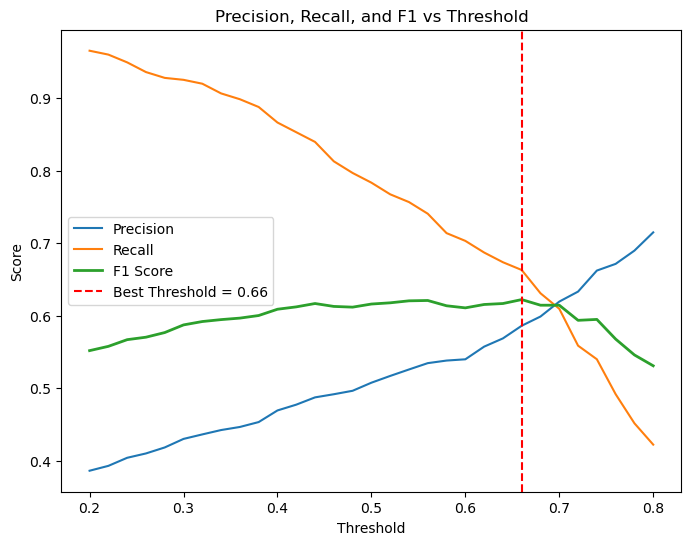

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision")
plt.plot(thr_df["threshold"], thr_df["recall"], label="Recall")
plt.plot(thr_df["threshold"], thr_df["f1"], label="F1 Score", linewidth=2)
plt.axvline(best_t, color="red", linestyle="--", label=f"Best Threshold = {best_t:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.show()


# Step 9 Conclusion
At 0.66, the model balances catching churners (recall) with avoiding false positives (precision). Depending on business priorities, the threshold can be adjusted lower (favor recall) or higher (favor precision).

# Overall Conclusion

This churn project turns modeling into action. After cleaning and encoding the Telco dataset and establishing a logistic-regression baseline (Accuracy≈0.80, F1_churn≈0.60), I addressed class imbalance and compared multiple models. Logistic Regression with class weights delivered the best churn capture (F1=0.616, AUC=0.843), while boosting models (HistGradientBoosting, XGBoost) offered a strong balance with competitive AUC and solid recall. Random Forest scored high on AUC/accuracy but under-detected churners, lowering F1. I then picked an operating threshold of 0.66 to align with business priorities, trading a bit of precision for better recall of at-risk customers.

What drives churn: month-to-month contracts, short tenure, higher monthly charges, electronic check payments, and certain service configurations (e.g., fiber without support).
What to do: incentivize term contracts for short-tenure customers, bundle support/security for fiber users, review pricing/loyalty for high-charge cohorts, and encourage auto-pay.

Bottom line: The final workflow not only predicts who is likely to churn but also prioritizes who to contact and why, translating model outputs into clear retention levers.